In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.integrate as spi
plt.style.use('seaborn-white')
%matplotlib inline

In [2]:
filename = 'data/ltb_cheese.csv'
df = pd.read_csv(filename)
df.head()

,DL,DLS,DS,numerical_thetas,om_lambdas,rs,rs_initial,step,theta
0,622.435157,59.425073,670.391723,0.000005,0.000000,819.570844,749.363511,1.000000e-07,1.000000e-06
1,623.866125,60.046202,672.298118,0.000005,0.020204,822.061660,751.091143,1.000000e-07,9.998403e-07
2,625.309897,60.686598,674.281533,0.000005,0.040408,824.586172,752.834275,1.000000e-07,9.996838e-07
3,626.766685,61.347160,676.290894,0.000005,0.060612,827.151972,754.593167,1.000000e-07,9.995307e-07
4,628.236710,62.028976,678.386495,0.000005,0.080816,829.753420,756.368083,1.000000e-07,9.993809e-07


In [3]:
df.values[0]

array([  6.22435157e+02,   5.94250732e+01,   6.70391723e+02,
         5.21620031e-06,   0.00000000e+00,   8.19570844e+02,
         7.49363511e+02,   1.00000000e-07,   1.00000000e-06])

In [4]:
# df = df[~((df.om_lambdas < 0.707144) & (df.om_lambdas > 0.707142))]

length_scale = 3.086e22
H_0 = 7.56e-27 * length_scale
M_total = 1474e12 / length_scale

# def calc_theta(D_LS, D_L, D_S):
#     return np.sqrt(4*M*D_LS/D_L/D_S)

theta_second_order = []
theta_rindler = []
for index, row in df.iterrows():
    Lambda = 3*row.om_lambdas*H_0**2
    enclosed_r = row.DL*row.theta
    rho_frw_initial = (1-row.om_lambdas)*3*H_0**2/(8*np.pi)
    r_h = (3*M_total/(4*np.pi*rho_frw_initial))**(1./3)
    
    def mass(r):
        initial_rh = (3*M_total/(4*np.pi*rho_frw_initial))**(1./3)
        rlimit = initial_rh*0.7
        if r > rlimit:
            return M_total
        else:
            c = 10
            Rvir = rlimit/100
            Rs = Rvir/c
            rho0 = M_total/(4*np.pi*Rs**3*(np.log((Rs + rlimit)/Rs) - rlimit/(Rs + rlimit)))
            return 4*np.pi*rho0*Rs**3*(np.log((Rs+r)/Rs) - r/(Rs+r))

    def rho(r):
        initial_rh = (3*M_total/(4*np.pi*rho_frw_initial))**(1./3)
        rlimit = initial_rh*0.7
        if r > rlimit:
            return 0
        else:
            c = 10
            Rvir = rlimit/100
            Rs = Rvir/c
            rho0 = M_total/(4*np.pi*Rs**3*(np.log((Rs + rlimit)/Rs) - rlimit/(Rs + rlimit)))
            return rho0/(r/Rs)/(1 + r/Rs)**2

    def projected_mass(r):
        initial_rh = (3*M_total/(4*np.pi*rho_frw_initial))**(1./3)
        rlimit = initial_rh*0.7
        if r > rlimit:
            return M_total
        else:
            c = 10
            Rvir = rlimit/100
            Rs = Rvir/c
            
            g = 1/(np.log(1+c) - c/(1+c))
            Rtilde = r / Rvir
            if r > Rs:
                c_inverse = np.arccos(1/c/Rtilde)
            else:
                c_inverse = np.arccosh(1/c/Rtilde)
            return 1/(np.log(1+c*Rtilde) - c*Rtilde/(1+c*Rtilde))*mass(r)*(c_inverse/np.abs(c**2*Rtilde**2-1)**(1/2) + np.log(c*Rtilde/2))

    M = projected_mass(enclosed_r)
        
    coeff = [row.DS + Lambda*row.DL*row.DLS*r_h/3, 0, -4*M*row.DLS/row.DL, -15*np.pi*M**2/4*row.DLS/row.DL**2, -305/12*M**3*row.DLS/row.DL**3]
#     if index < 50:
#         print(row.om_lambdas, 15*np.pi/4*M**2/(row.DL*row.theta)**2, Lambda*(row.DL*row.theta)*r_h/3)
    roots = np.roots(coeff)
    roots = roots[roots>0 & np.isreal(roots)]
    th = np.real(roots)
    rindler = th[np.argmin(np.abs(row.theta - th))]

    # coeff2 = [row.DS, -4*M*row.DLS/row.DL, 8*M**3*row.DLS/row.DL**3]
    coeff2 = [row.DS, 0, -4*M*row.DLS/row.DL, -15*np.pi*M**2/4*row.DLS/row.DL**2, -401/12*M**3*row.DLS/row.DL**3]
    roots2 = np.roots(coeff2)
    roots2 = roots2[roots2>0 & np.isreal(roots2)]
    th2 = np.real(roots2)
    second_order = th2[np.argmin(np.abs(row.theta - th2))]
    theta_rindler.append(rindler)
    theta_second_order.append(second_order)

df['theta_second_order'] = theta_second_order
df['theta_rindler'] = theta_rindler


# ## removed percentage!!
df['percentage_diff'] = (df.theta_second_order - df.theta)/df.theta
df['rindler_preds'] = (df.theta_rindler - df.theta)/df.theta

In [5]:
df.head()

,DL,DLS,DS,numerical_thetas,om_lambdas,rs,rs_initial,step,theta,theta_second_order,theta_rindler,percentage_diff,rindler_preds
0,622.435157,59.425073,670.391723,0.000005,0.000000,819.570844,749.363511,1.000000e-07,1.000000e-06,9.999839e-07,9.999839e-07,-0.000016,-0.000016
1,623.866125,60.046202,672.298118,0.000005,0.020204,822.061660,751.091143,1.000000e-07,9.998403e-07,9.998604e-07,9.998604e-07,0.000020,0.000020
2,625.309897,60.686598,674.281533,0.000005,0.040408,824.586172,752.834275,1.000000e-07,9.996838e-07,9.997053e-07,9.997053e-07,0.000022,0.000021
3,626.766685,61.347160,676.290894,0.000005,0.060612,827.151972,754.593167,1.000000e-07,9.995307e-07,9.995566e-07,9.995564e-07,0.000026,0.000026
4,628.236710,62.028976,678.386495,0.000005,0.080816,829.753420,756.368083,1.000000e-07,9.993809e-07,9.993705e-07,9.993703e-07,-0.000010,-0.000011


In [6]:
stats = df[['om_lambdas', 'percentage_diff', 'rindler_preds']].groupby('om_lambdas').agg(['mean', 'std', 'count'])
stats.columns = [' '.join(col).strip() for col in stats.columns.values]
stats['percentage_diff mean std'] = stats['percentage_diff std']/np.sqrt(stats['percentage_diff count'])
stats['rindler_preds mean std'] = stats['rindler_preds std']/np.sqrt(stats['rindler_preds count'])
stats

,percentage_diff mean,percentage_diff std,percentage_diff count,rindler_preds mean,rindler_preds std,rindler_preds count,percentage_diff mean std,rindler_preds mean std
om_lambdas,,,,,,,,
0.000000,0.000015,0.000053,20,1.461410e-05,0.000053,20,0.000012,0.000012
0.020204,0.000031,0.000099,20,3.056657e-05,0.000099,20,0.000022,0.000022
0.040408,0.000040,0.000097,20,4.010539e-05,0.000097,20,0.000022,0.000022
0.060612,0.000027,0.000089,20,2.724347e-05,0.000089,20,0.000020,0.000020
0.080816,-0.000021,0.000083,20,-2.172442e-05,0.000083,20,0.000019,0.000019
0.101020,0.000014,0.000095,20,1.403898e-05,0.000095,20,0.000021,0.000021
0.121224,-0.000002,0.000085,20,-2.882556e-06,0.000085,20,0.000019,0.000019
0.141429,0.000016,0.000123,20,1.554028e-05,0.000123,20,0.000028,0.000028
0.161633,0.000004,0.000070,20,3.468233e-06,0.000070,20,0.000016,0.000016


In [7]:
stats.values[0]

array([  1.46141075e-05,   5.28235712e-05,   2.00000000e+01,
         1.46140988e-05,   5.28235712e-05,   2.00000000e+01,
         1.18117096e-05,   1.18117096e-05])

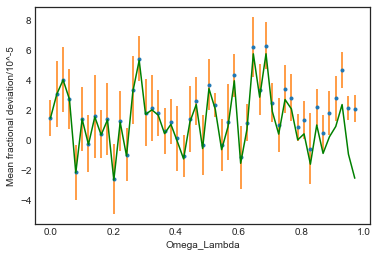

In [11]:
scale = 1e-5
plt.plot(stats.index, stats['percentage_diff mean']/scale, '.')
plt.errorbar(stats.index, stats['percentage_diff mean']/scale, yerr=stats['percentage_diff mean std']/scale, linestyle='none')
plt.xlabel('Omega_Lambda')
plt.ylabel('Mean fractional deviation/10^-5')
plt.plot(stats.index, stats['rindler_preds mean']/scale, 'g-')
plt.savefig('images/fractional deviation ltb.png', dpi=400)
# plt.errorbar(stats.index, stats['rindler_preds mean']/scale, yerr=stats['rindler_preds mean std']/scale, linestyle='none')

In [ ]:
from util import plot_diff_lambdas
plt.figure()
plt.title("vode")
plot_diff_lambdas('data/diff_lambdas_small2.csv', recalculate_distances=True)
plot_diff_lambdas('data/diff_lambdas_step.csv', plot_rindler=True)
plot_diff_lambdas('data/diff_lambdas_step2.csv')
plt.figure()
plt.title("dopri5")
plot_diff_lambdas('data/dopri5_diff_lambdas.csv')
plot_diff_lambdas('data/dopri5_diff_lambdas2.csv', plot_rindler=True)
plt.figure()
plt.title("dop853")
plot_diff_lambdas('data/dop853_diff_lambdas.csv')
plot_diff_lambdas('data/dop853_diff_lambdas2.csv')

In [ ]:
# configure plotting
import importlib
import util
util = importlib.reload(util)

from matplotlib import rc, rcParams
rc('text', usetex=True)
plt.rc('font', family='serif')
%config InlineBackend.rc = {'figure.dpi': 600, 'savefig.dpi': 300, \
                            'font.size': 30, \
                            'figure.facecolor': (1, 1, 1, 0)}
util.plot_diff_lambdas('data/diff_lambdas_bigger_redshifts2.csv', plot_rindler=True)
# ax = plt.gca()
plt.xlabel(u"$\Omega_{\Lambda}$", size=14)
plt.ylabel('Mean fractional deviation / $10^{-5}$', size=14)
# plt.legend()
# plt.savefig('images/fractional_deviations_const_M_without_rindler.png', dpi=400, transparent=True)